In [1]:
import os
from pathlib import Path
import torch
from torchvision import transforms as T
from PIL import Image
import numpy as np
import clip
import matplotlib.pyplot as plt
from glob import glob

In [2]:
device ='cuda:0'
clip_name = "ViT-B/16" 
clip_model, clip_preprocess = clip.load(clip_name, device=device)


100%|███████████████████████████████████████| 335M/335M [00:08<00:00, 39.0MiB/s]


In [53]:
artistic_styles = [
    'realistic photo',
    'picasso painting',
    #'van gogh',
    'oil painting',
    'stained glass',
    'ukiyoe drawing',
    #'computer graphics',
    'cyberpunk japanese anime',
    #'grunge street art',
    #'color sketch',
    'Disney cartoon',    
    
]
artistic_styles_dict = {style: index for index, style in enumerate(artistic_styles)}

person_texts = [
    'a person wearing tank top and short',
    'a person wearing t-shirt',
    'a person wearing long sleeve',
    'a person wearing gown',
    #'nobody in the picture',
]

In [30]:
def calc_clip_(image, artistic_text, person_text, debug=False):
    if debug:
        plt.imshow(image)
        plt.show()               
    image = clip_preprocess(image).unsqueeze(0).to(device)
    artistic_token = clip.tokenize(artistic_text).to(device)
    person_token = clip.tokenize(person_text).to(device)
    
    #image = torch.cat((gt_image, result_image))
    with torch.no_grad():
        #image_features = clip_model.encode_image(image)
        #text_features = clip_model.encode_text(text)
        
        #image_features /= image_features.norm(dim=-1, keepdim=True)
        #text_features /= text_features.norm(dim=-1, keepdim=True)
        #similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
        #print('text similarity', similarity[0,0])        
        
        logits_per_image, logits_per_text = clip_model(image, artistic_token)
        probs = logits_per_image.softmax(dim=-1).cpu().view(-1).numpy()
        artistic_id = probs.argmax()
        artistic_result = artistic_text[artistic_id]
        
        logits_per_image, logits_per_text = clip_model(image, person_token)
        probs = logits_per_image.softmax(dim=-1).cpu().view(-1).numpy()
        person_id = probs.argmax()
        person_result = person_text[person_id]        
        if debug:    
            print(artistic_result, ',', person_result)
    return artistic_id, person_id
    #sim = similarity[0,0]
    #if debug:
    #    print(sim)
    #return sim
    


In [56]:
root = Path("/home/soon/github/visconet/test_output_control/")
stats = {}
for art_style in artistic_styles[1:]:
    
    art_style_id = artistic_styles_dict[art_style]            
    folder = root/art_style.replace(' ','_')
    for subfolder in ["baseline","mode"][1:]:
        person_data = []
        art_data = []  
        person_texts = [
            f'a person wearing tank top and short in the style of {art_style}',
            f'a person wearing tank top and short in realistic photo',
            'a person standing'
            #'nobody in the picture',
        ]        
        files = glob(str(folder/subfolder/'*.png'))
        print(art_style, subfolder, f'{len(files)} files')
        
        for f in files:
            art_id, person_id = calc_clip_(Image.open(f), artistic_styles, person_texts, False)
            art_data.append(art_id)
            person_data.append(person_id)

        art_acc = np.mean(np.array(art_data)==art_style_id)
        person_acc = np.mean(np.array(person_data)==0)
        print(f'    {subfolder}-> art={art_acc}  person={person_acc}')
        stats[art_style] = {'art_acc':art_acc, 'person_acc':person_data}
        if art_acc<0.7:
            unique_elements, counts = np.unique(np.array(art_data), return_counts=True)
            top_indices = np.argsort(counts)[-3:][::-1]
            most_frequent_item = unique_elements[np.argmax(counts)]
            top_elements = unique_elements[top_indices]
            top_counts = counts[top_indices]
            rank_str = ''
            for i, (element, count) in enumerate(zip(top_elements, top_counts), 1):
                rank_str += f'  {i}: {artistic_styles[element]}:{count}    '
            print(rank_str+'\n')            
            
        if person_acc<0.7:
            unique_elements, counts = np.unique(np.array(person_data), return_counts=True)
            top_indices = np.argsort(counts)[-3:][::-1]
            most_frequent_item = unique_elements[np.argmax(counts)]
            top_elements = unique_elements[top_indices]
            top_counts = counts[top_indices]
            rank_str = ''
            for i, (element, count) in enumerate(zip(top_elements, top_counts), 1):
                rank_str += f'  {i}: {person_texts[element]}:{count}    '
            print(rank_str+'\n')                  


picasso painting mode 100 files
    mode-> art=1.0  person=1.0
oil painting mode 100 files
    mode-> art=1.0  person=1.0
stained glass mode 100 files
    mode-> art=1.0  person=1.0
ukiyoe drawing mode 100 files
    mode-> art=1.0  person=1.0
cyberpunk japanese anime mode 100 files
    mode-> art=0.77  person=0.88
Disney cartoon mode 100 files
    mode-> art=0.74  person=0.74


In [20]:
unique_elements, counts = np.unique(np.array(art_data), return_counts=True)
top_indices = np.argsort(counts)[-3:][::-1]
most_frequent_item = unique_elements[np.argmax(counts)]
top_elements = unique_elements[top_indices]
top_counts = counts[top_indices]
rank_str = ''
for i, (element, count) in enumerate(zip(top_elements, top_counts), 1):
    rank_str += f'  {i}: {artistic_styles[element]}:{count}    '
print(rank_str)

  1: grunge street art:46      2: realistic:4    


In [166]:
np.mean(np.array(person_data)==0)

0.36

In [114]:
root = "/home/soon/github/visconettest_output_nomask/"

image_files = glob(root+'*.jpg')
print(len(image_files))


40


In [120]:
file_id = 0
image = Image.open(image_files[file_id])

FileNotFoundError: [Errno 2] No such file or directory: '/home/soon/github/HumanSD/output/controlnet/realistic_photo/0.jpg'

In [122]:
image  = Image.open('grudge.png')

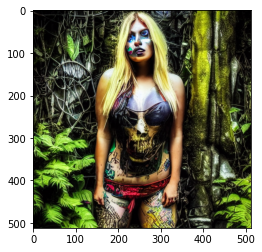

['realistic photo', 'picasso painting', 'oil painting', 'stained glass', 'ukiyoe drawing', 'cartoon drawing', 'computer graphics', 'kids drawing', 'cyberpunk japanese anime', 'grunge street art']
text similarity 0.2219
[3.122e-02 4.032e-03 1.429e-02 1.399e-01 1.264e-05 8.270e-03 7.373e-02
 6.185e-04 2.843e-02 6.997e-01]
result: grunge street art


In [14]:
probs.argmax()

0

0